Copy of Fork of VPP ver 6, the one that scored 2.37

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Load Files

In [2]:
%%time
# Load files
train = pd.read_csv(r'C:\Sync\Work\Kaggle Competitions\Ventilator Pressure Prediction\Data\train.csv')
test = pd.read_csv(r'C:\Sync\Work\Kaggle Competitions\Ventilator Pressure Prediction\Data\test.csv')
# train = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/train.csv')
# test = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/test.csv')

y = train['pressure']

Wall time: 4.82 s


# Reduce data size

In [3]:
mem_train_init = train.memory_usage().sum()
mem_test_init = test.memory_usage().sum()
mem_train_init

386304128

In [4]:
# down convert columns to save memory...

# train
train['id'] = train['id'].astype(np.int32)
train['breath_id'] = train['breath_id'].astype(np.int32)
train['R'] = train['R'].astype(np.int8)  #or OHC?
train['C'] = train['C'].astype(np.int8)
train['u_out'] = train['u_out'].astype(np.int8)
train['u_in'] = train['u_in'].astype(np.float32)
train['time_step'] = train['time_step'].astype(np.float32)

#test
test['id'] = test['id'].astype(np.int32)
test['breath_id'] = test['breath_id'].astype(np.int32)
test['R'] = test['R'].astype(np.int8)  #or OHC?
test['C'] = test['C'].astype(np.int8)
test['u_out'] = test['u_out'].astype(np.int8)
test['u_in'] = test['u_in'].astype(np.float32)
test['time_step'] = test['time_step'].astype(np.float32)

# check that they converted
for col in train.columns:
    print(train[col].dtype)
    
for col in test.columns:
    print(test[col].dtype)  

int32
int32
int8
int8
float32
float32
int8
float64
int32
int32
int8
int8
float32
float32
int8


In [5]:
# why did they reduce in different percentages?  
mem_train_post = train.memory_usage().sum()
mem_test_post = test.memory_usage().sum()
print(f'New train memory: {mem_train_post/1024**2:.1f}MB/{mem_train_init/1024**2:.1f}MB, reduction = {100*mem_train_post/mem_train_init:.1f}%')
print(f'New test memory: {mem_test_post/1024**2:.1f}MB/{mem_test_init/1024**2:.1f}MB, reduction = {100*mem_test_post/mem_test_init:.1f}%')

train.head()

New train memory: 155.4MB/368.4MB, reduction = 42.2%
New test memory: 72.9MB/214.9MB, reduction = 33.9%


,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509277,0,7.876254
3,4,1,20,50,0.101542,22.808823,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


# Split into inhalitory and exhailtory groups (only scored on inhale)

In [6]:
train_in = train[train.u_out == 0]
test_in = test[test.u_out == 0]
y_in = train_in['pressure']

train_out = train[train.u_out == 1]
test_out = test[test.u_out == 1]

In [7]:
train_out.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
30,31,1,20,50,1.021298,0.0,1,19.546410
31,32,1,20,50,1.055426,0.0,1,17.015533
32,33,1,20,50,1.089404,0.0,1,9.563505
33,34,1,20,50,1.123387,0.0,1,7.876254
34,35,1,20,50,1.157591,0.0,1,8.649578


# Add Features

1. Apply lag shift (tested shift =1 ) \
    * Shift = 2 performs better (2.37 vs. 2.0x
2. Add differentials for dt and du_in
3. Add integral column for d_uin

In [8]:
# apply lag shift in training set
u_in_lag = train_in.u_in.shift(3,fill_value=0)
train_in['u_in_lag'] = u_in_lag
train_in.drop(['u_in'],axis=1,inplace=True)

# and for test set
u_in_lag = test_in.u_in.shift(3,fill_value=0)
test_in['u_in_lag'] = u_in_lag
test_in.drop(['u_in'],axis=1,inplace=True)

<ipython-input-8-d57519076511>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_in['u_in_lag'] = u_in_lag
C:\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-8-d57519076511>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_in[

In [9]:
# add dt and du_in to train_in
dt = np.diff(train_in.time_step)
ldt = list(dt)
ldt.append(ldt[-1])
du_in = np.diff(train_in.u_in_lag)
ldu_in = list(du_in)
ldu_in.append(ldu_in[-1])
train_in['dt'] = ldt
train_in['d_u_in'] = ldu_in
 
# Add dt and du_in to test_in
dt = np.diff(test_in.time_step)
ldt = list(dt)
ldt.append(ldt[-1])
du_in = np.diff(test_in.u_in_lag)
ldu_in = list(du_in)
ldu_in.append(ldu_in[-1])
test_in['dt'] = ldt
test_in['d_u_in'] = ldu_in

<ipython-input-9-3605c3e0385f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_in['dt'] = ldt
<ipython-input-9-3605c3e0385f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_in['d_u_in'] = ldu_in
<ipython-input-9-3605c3e0385f>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

### Add integral column

In [10]:
# add integral
breath_id_idx = train_in.breath_id.unique()

In [11]:
# function to get single breath (id must exist...there are some that are missing)
# also once removed u_out=1, lengths are not always 30 (some 28, etc)
def get_breath(df,my_id):
    return df[df.breath_id == my_id] 

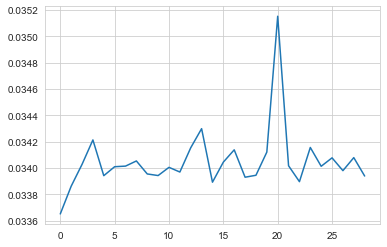

In [12]:
dt1 = get_breath(train_in,1)
plt.plot(dt1.dt[0:-1])

In [13]:
# Add integral column


In [14]:
test_in.head()

,id,breath_id,R,C,time_step,u_out,u_in_lag,dt,d_u_in
0,1,0,5,20,0.000000,0,0.000000,0.031904,0.000000
1,2,0,5,20,0.031904,0,0.000000,0.031924,0.000000
2,3,0,5,20,0.063827,0,0.000000,0.031924,0.000000
3,4,0,5,20,0.095751,0,0.000000,0.031893,7.515046
4,5,0,5,20,0.127644,0,7.515046,0.031914,7.136630


10/17/21 New in this run:
* Shifted by time lag 0f 2
* Added two new features:
    * dt
    * du_in


# Model

In [15]:
from sklearn.metrics import mean_absolute_error # ,confusion_matrix, classification_report

In [16]:
# Split data - after all analysis is done
from sklearn.model_selection import train_test_split

train_in.drop(columns = ['pressure','id','breath_id'], inplace = True)
#test = test.drop(columns = 'id', inplace = True)

X_train, X_valid, y_train, y_valid = train_test_split(train_in, y_in, train_size=0.8, test_size=0.2,
                                                      random_state=12)
X_test_in = test_in.copy().drop(columns=['id','breath_id'])

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [17]:
# from sklearn.tree import DecisionTreeRegressor

# for i in range(100,200,20): 
#     model_dt = DecisionTreeRegressor(n_estimators = i, max_depth=16, random_state=12)
#     model_dt.fit(X_train, y_train)
#     pred_dt = model_dt.predict(X_valid)

#     #dt = roc_auc_score(y_valid,pred_dt)
#     dt_mae_score = mean_absolute_error(pred_dt, y_valid)
#     print(f'Decision Tree MAE Score for max_depth={i} is : {dt_mae_score}')
# with default params, score = 2.413, but lb = 4.791.  Why the large difference?
# 11/17/21 changed to inhale only and my scores are matching better
    
# Decision Tree MAE Score for max_depth=2 is : 6.3443955300614405
# Decision Tree MAE Score for max_depth=3 is : 6.028395026290743
# Decision Tree MAE Score for max_depth=4 is : 5.678540615661189
# Decision Tree MAE Score for max_depth=5 is : 5.3517588341023155
# Decision Tree MAE Score for max_depth=6 is : 4.952135011724083
# Decision Tree MAE Score for max_depth=7 is : 4.669474094251829
# Decision Tree MAE Score for max_depth=8 is : 4.430497791001828
# Decision Tree MAE Score for max_depth=9 is : 4.235200007248183
# Decision Tree MAE Score for max_depth=10 is : 4.111949020503175
# Decision Tree MAE Score for max_depth=11 is : 4.002433270178995
# Decision Tree MAE Score for max_depth=12 is : 3.9195341438467897
# Decision Tree MAE Score for max_depth=13 is : 3.84778054263597
# Decision Tree MAE Score for max_depth=14 is : 3.79583210088494
# Decision Tree MAE Score for max_depth=15 is : 3.75439201392607
# Decision Tree MAE Score for max_depth=16 is : 3.7410021329185414
# Decision Tree MAE Score for max_depth=17 is : 3.744247688109701
# Decision Tree MAE Score for max_depth=18 is : 3.7645064417036505
# Decision Tree MAE Score for max_depth=19 is : 3.800083196701423
# Decision Tree MAE Score for max_depth=20 is : 3.852334638461889
# Decision Tree MAE Score for max_depth=21 is : 3.911532812448746
# Decision Tree MAE Score for max_depth=22 is : 3.9779119228181203
# Decision Tree MAE Score for max_depth=23 is : 4.044951907548471
# Decision Tree MAE Score for max_depth=24 is : 4.112202068631238
# min at max_depth=16 (3.741)


In [18]:
%%time
#random forest
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_valid)
rf_mae = mean_absolute_error(pred_rf,y_valid)
print(f'Random Forest MAE Score: {rf_mae}')

# (n_estimators=100, max_depth=7,min_samples_leaf=0.06, random_state=12), mae=3.12775, lb score = 6.431(?)
# Why is random forest worse?  
# 10/17/21: Still worse after using only inhales
# defaults: runs out of memory!!!???
# (n_estimators=100, max_depth=7,min_samples_leaf=0.06, random_state=12) = 5.867
# reduced dtype sizes on ints: 
# 3.627 default, lb = 3.710
# changed criterion to mae...doesn't work...removed

# with dt and du_in, shift=1, 2.364 vs. lb of 2.37.  Beats catboost (400,.6)
# with dt and du_in, shift=2, Random Forest MAE Score: 2.058162936194095
# with dt and du_in, shift=3, Random Forest MAE Score: 2.03014981349922
# interesting shift 3 is a little better.


Random Forest MAE Score: 2.03014981349922
Wall time: 18min 30s


In [19]:
%%time
from catboost import CatBoostRegressor
# loop for manual type cv
#preds = []
#for i in np.arange(1,2):
#     X_train, X_valid, y_train, y_valid = train_test_split(train, y, train_size=0.8, test_size=0.2,
#                                                       random_state=i)
model_cat = CatBoostRegressor(loss_function="MAE",
                               eval_metric="MAE",
                               task_type="GPU",
                               learning_rate=.6,
                               iterations=8000,
                               l2_leaf_reg=50,
                               random_seed=12,
                               od_type="Iter",
                               depth=5,
                               #early_stopping_rounds=6500,
                               border_count=64,
                               verbose=False
                              )
model_cat.fit(X_train,y_train)
pred_cat = model_cat.predict(X_valid)
score_cat = mean_absolute_error(y_valid,pred_cat)
#print(f'iters={i}, lr={j}, CatBoost MAE Score: {score_cat}')
print(f'CatBoost MAE Score: {score_cat}')
#preds.append(model_cat.predict_proba(X_test)[:,1])
# 400, .6 = 3.976
# 400, .6 with shift=1 and dt, duin = 2.97
# 1000, .6, " " = 2.79
# 4000, .6  "" = 2.64
# 8000 same = 2.59
# 8000 with shift=2: 2.26299, still worse than rf = 2.058
# repeat with shift=3, 2.263788

CatBoost MAE Score: 2.2637883266795598
Wall time: 2min 26s


In [20]:
model_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Final Model

In [21]:
# create outpreds = average out value
out_preds = np.ones(len(test_out))
i = list(test_out.id)
out_preds_s = pd.Series(out_preds,index = i)
out_preds_s

32         1.0
33         1.0
34         1.0
35         1.0
36         1.0
          ... 
4023996    1.0
4023997    1.0
4023998    1.0
4023999    1.0
4024000    1.0
Length: 2496435, dtype: float64

In [22]:
pred_final = model_rf.predict(X_test_in)
# add indexs to recombine with out preds
pred_final_s = pd.Series(pred_final,index=list(test_in.id))
pred_final_s.head()

1    6.280360
2    6.371085
3    9.871429
4    6.703614
5    8.351496
dtype: float64

In [23]:
both = pred_final_s.append(out_preds_s).sort_index()
both.values

array([6.28036007, 6.37108499, 9.87142881, ..., 1.        , 1.        ,
       1.        ])

In [24]:
output = pd.DataFrame({'id': test.id, 'pressure': both.values})
output.to_csv('submission.csv', index=False)
print("Submission saved!")

Submission saved!
